<a href="https://colab.research.google.com/github/pengzer1/abuse_classification/blob/main/abuse_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 분류를 위한 준비

형태소 분석기 Mecab을 이용하기 위해 설치

In [1]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 115 (delta 11), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (115/115), 1.27 MiB | 30.25 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 5.7 MB/s 
     |████████████████████████████████| 453 kB 63.7 MB/s 
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-05-29 05:34:01--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 18.205.93.1, 18.205.93.0, 18.205.93.2, ...
Connecting to bitbucket.org (bitbucket.org)|18.205.93.1|:443

In [204]:
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

dataset의 경우, https://github.com/2runo/Curse-detection-data/blob/master/dataset.txt의 dataset을 사용

In [205]:
def replace_in_file(file_path, old_str, new_str):
    # 파일 읽어들이기
    fr = open(file_path, 'r')
    lines = fr.readlines()
    fr.close()
    
    # old_str -> new_str 치환
    fw = open(file_path, 'w')
    for line in lines:
        fw.write(line.replace(old_str, new_str))
    fw.close()

# 호출: file1.txt 파일에서 comma(,) 없애기
replace_in_file("/content/dataset.txt", "|", "\t")

# 전처리 과정

In [225]:
total_data = pd.read_table('/content/dataset.txt', names=['comment', 'label'])
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 5825


In [226]:
total_data[:5]

,comment,label
0,좌배 까는건 ㅇㅂ,1
1,집에 롱 패딩만 세 개다. 10년 더 입어야지 ㅋㅋ,0
2,개소리야 니가 빨갱이를 옹호하고 드루킹을 ㅇㅇ짓이라고 말못해서 삐진거야 빨갱아,1
3,세탁이라고 봐도 된다,0
4,애새끼가 초딩도 아니고 ㅋㅋㅋㅋ,1


In [227]:
print(total_data.isnull().values.any())

False


In [228]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 4368
테스트용 리뷰의 개수 : 1457


In [229]:
train_data['comment'] = train_data['comment'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['comment'].replace('', np.nan, inplace=True)
train_data = train_data.dropna(how='any') # Null 값 제거
print('전처리 후 훈련용 샘플의 개수 :',len(train_data))

전처리 후 훈련용 샘플의 개수 : 4358


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [247]:
test_data.drop_duplicates(subset = ['comment'], inplace=True) # 중복 제거
test_data['comment'] = test_data['comment'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['comment'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 1449


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


토큰화

In [248]:
mecab = Mecab()

In [249]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [250]:
train_data['tokenized'] = train_data['comment'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [251]:
test_data['tokenized'] = test_data['comment'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [270]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [271]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

샘플 정리, 1 이하인 희귀 단어 등장 빈도 비율이 10퍼센트 였기 때문에 희귀 단어 제거는 하지 않았음

In [272]:
threshold = 1
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 9958
등장 빈도가 0번 이하인 희귀 단어의 수: 0
단어 집합에서 희귀 단어의 비율: 0.0
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.0


In [273]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 9960


In [274]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

댓글의 최대 길이 : 336
댓글의 평균 길이 : 12.505277650298302


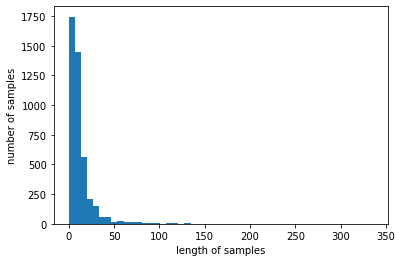

In [275]:
print('댓글의 최대 길이 :',max(len(review) for review in X_train))
print('댓글의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

샘플 길이가 80 이하인 샘플의 비율이 99퍼였기 때문에 샘플 길이는 80으로 설정

In [276]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.01330885727397


In [277]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [282]:
import re
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [283]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
313/313 [==============================] - ETA: 0s - loss: 0.4710 - acc: 0.7700
Epoch 1: val_acc improved from -inf to 0.83180, saving model to best_model.h5
313/313 [==============================] - 53s 162ms/step - loss: 0.4710 - acc: 0.7700 - val_loss: 0.4087 - val_acc: 0.8318
Epoch 2/15
313/313 [==============================] - ETA: 0s - loss: 0.3201 - acc: 0.8659
Epoch 2: val_acc did not improve from 0.83180
313/313 [==============================] - 50s 161ms/step - loss: 0.3201 - acc: 0.8659 - val_loss: 0.4047 - val_acc: 0.8290
Epoch 3/15
313/313 [==============================] - ETA: 0s - loss: 0.2667 - acc: 0.8928
Epoch 3: val_acc improved from 0.83180 to 0.84840, saving model to best_model.h5
313/313 [==============================] - 50s 160ms/step - loss: 0.2667 - acc: 0.8928 - val_loss: 0.3756 - val_acc: 0.8484
Epoch 4/15
313/313 [==============================] - ETA: 0s - loss: 0.2237 - acc: 0.9134
Epoch 4: val_acc did not improve from 0.84840
313/313 [====

In [284]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

782/782 [==============================] - 17s 21ms/step - loss: 0.4005 - acc: 0.8372

 테스트 정확도: 0.8372


In [285]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(loaded_model.predict(pad_new))
  if(score > 0.6):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [307]:
sentiment_predict('안녕하세요 반갑습니다')

73.13% 확률로 긍정 리뷰입니다.


In [308]:
sentiment_predict('페이커는 신이야!')

75.39% 확률로 긍정 리뷰입니다.


In [305]:
sentiment_predict('틀딱 씨발새끼들아 다꺼져라 냄새나니까')

61.13% 확률로 부정 리뷰입니다.


In [304]:
sentiment_predict('짱깨들 말하는 거임? 짱깨국이 무상의료라고?')

60.19% 확률로 부정 리뷰입니다.


In [310]:
sentiment_predict('골빈 ㄴ이 존나 나대네 ㅋㅋㅋㅋ 틀딱 냄새 나니까 꺼져')

64.39% 확률로 부정 리뷰입니다.
